# Model Exploration

In this notebook, we plot the RGB, DSM, and DTM data side by side, and layer the ground-truth mask as well as the predicted mask over the RGB data. We also present the accuracy metrics of the model on the RGB + DSM/DTM data.

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import georaster
import torch
import json
from pytorch_utils.eval import read_model, predict, flip
from nbutils import thresh, score_pred, load_img
from config import Config
%matplotlib inline

Albu's final solution uses 4 channels (RGB and (DSM - DTM)), but his model begins training with only RGB data. It's possible to try using only 3 channels.

In [2]:
cfg_f = '../resnet34_1x1080_retrain.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
cfg = Config(**cfg)
# When we have satellite imagery & depth-mapping
# See end of file for attempt at using only imagery
model = read_model(cfg, 4)

### Examine the Satellite Imagery and Depth Mapping

If you'd like to save the figure for more detailed exploration, uncomment the line below

Note: we can actually plot the corresponding latitude & longitude for each axis, but it introduces distortion.


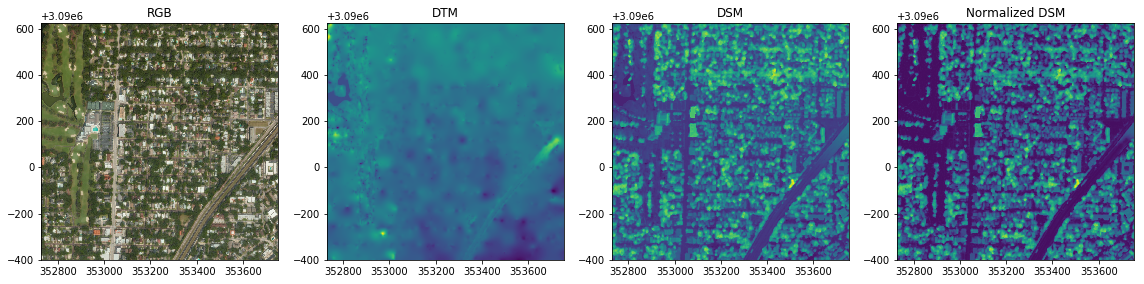

In [3]:
fname = '../../Train/Inputs/TAM_Tile_099_RGB.tif'
dsmname = fname.replace('RGB', 'DSM')
dtmname = fname.replace('RGB', 'DTM')
img = load_img(fname, tiff=False)
fig, axes = plt.subplots(ncols=4, figsize=(16,8))
geo_img = georaster.MultiBandRaster(fname, load_data=False)
dtm_img = georaster.SingleBandRaster(dtmname).r
dsm_img = georaster.SingleBandRaster(dsmname).r
dem_img = (dsm_img - dtm_img) / 9.0
axes[0].imshow(img, extent=geo_img.extent)
axes[0].set_title("RGB")
axes[1].imshow(dtm_img, extent=geo_img.extent)
axes[1].set_title("DTM")
axes[2].imshow(dsm_img, extent=geo_img.extent)
axes[2].set_title("DSM")
axes[3].imshow(dem_img, extent=geo_img.extent)
axes[3].set_title("Normalized DSM")
fig.tight_layout()
# fig.savefig('Satellite+Depth.png', dpi=200)
print("""Note: we can actually plot the corresponding latitude & longitude for each axis, but it introduces distortion.""")

### Create Polygons from Ground Truth Labels

63 0 0.5931944847106934


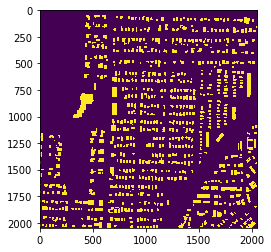

In [4]:
lblname='../../Train/GT/TAM_Tile_099_GTL.tif'
geo_lbl = georaster.SingleBandRaster(lblname)
lbl = geo_lbl.r - 2
plt.imshow(lbl, extent=geo_lbl.extent)
print(lbl.max(), lbl.min(), lbl.mean())
retval, dst = cv2.threshold(lbl, 0.5, maxval=lbl.max(), type=0)
im2, contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(dst)

### Combining the Satellite Imagery with Polygon Labels

Here we develop some tools that will plot ground truth & predicted polygon labels. In the following portions, we will develop the ability to predict using the model.

In [5]:
from matplotlib.collections import PatchCollection
TRUE_COLOR = (0, 0.2, 0.9, 0.6)
PRED_COLOR = (0, 0.9, 0, 0.4)
def plot_poly(contours, ax, coord_fn, color=TRUE_COLOR):
    """Plots a polygon where contours is a list of M polygons. Each polygon is an Nx2 array of 
    its vertices. Coord_fn is meant to be the coordinate function of a georaster image."""
    p = []
    for i, poly in enumerate(contours):
        # Avoid degenerate polygons
        if len(poly) < 3:
            continue
        pts = np.array(poly).squeeze()
        try:
            xs, ys = geo_img.coordinates(Xpixels=list(pts[:, 0]), Ypixels=list(pts[:, 1]))
        except IndexError as e:
            print("error on translating poly {}".format(i))
        p.append(plt.Polygon(np.vstack([xs, ys]).T, facecolor='red'))
    col = PatchCollection(p)
    col.set_color(color)
    ax.add_collection(col)
    xs, ys = coord_fn([0, len(img)], [0, img.shape[1]-1], latlon=True)


#### An example with the ground truth

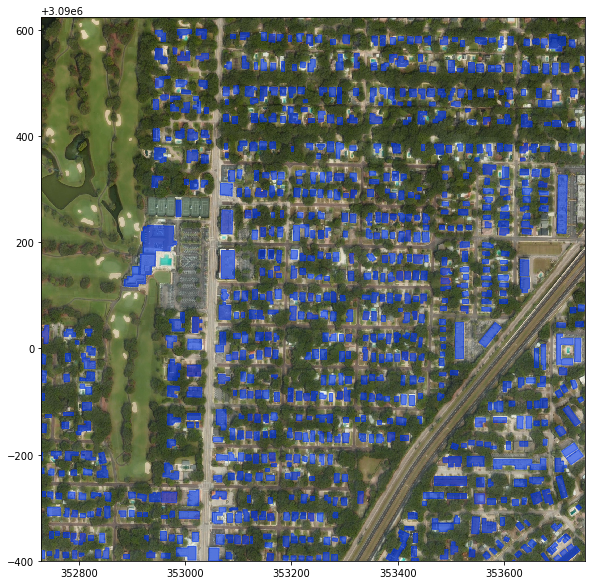

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img, extent=geo_img.extent)
plot_poly(contours, ax, geo_img.coordinates)
plt.show()

#### Predicting with the pretrained model

We replicate a few ensembling and averaging techniques traditionally used to improve ensemble accuracy, however, there we are still missing some of the subtlety to Albu's solution. Albu trains 5 models on 5 different folds of the dataset, and ensembles their predictions on the flips. We, however, are only using 1 model from the last of the 5 folds. Here we use window-crops.

In [7]:
def big(x, axis=-1):
    return np.expand_dims(x, axis=axis)

def get_crops(img):
    "assumes img is 2048 and target is 1024"
    return img[:1024, :1024], img[:1024, 1024:], img[1024:, :1024], img[1024:, 1024:]

def reconstruct(ul, ur, ll, lr):
    up = np.concatenate((ul, ur), axis=1)
    down = np.concatenate((ll, lr), axis=1)
    return np.concatenate((up, down), axis=0)

def predict_on_file(model, fname, crop=True, flips=flip.FLIP_FULL, channels=4):
    """Predicts using RGB fname, loads in DTM+DSM data as well"""
    original_img = load_img(fname) / 255.0
    dsm = georaster.SingleBandRaster(fname.replace('RGB', 'DSM')).r
    dtm = georaster.SingleBandRaster(fname.replace('RGB', 'DTM')).r
    original_dem = (dsm - dtm) / 9.0
    pred_array = []
    if crop:
        for img, dem_img in zip(get_crops(original_img), get_crops(original_dem)):
            if channels == 4:
                input_tensor = np.dstack([big(img[:,:,0]), big(img[:,:,1]), 
                                      big(img[:,:,2]), big(dem_img)])
            else:
                input_tensor = img
            with torch.no_grad():
                input_tensor = torch.Tensor(np.expand_dims(np.transpose(input_tensor, (2, 0, 1)),axis=0))
                out = predict(model, torch.autograd.Variable(input_tensor).cuda(), flips=flips)

            pred_array.append(np.transpose((out[0]*255).astype(np.uint8), (1, 2, 0)).squeeze())
        return reconstruct(*pred_array)
    else:
        img = original_img
        dem_img = original_dem
        if channels == 4:
            input_tensor = np.dstack([big(img[:,:,0]), big(img[:,:,1]), 
                                      big(img[:,:,2]), big(dem_img)])
        else:
            input_tensor = img
        with torch.no_grad():
            input_tensor = torch.Tensor(np.expand_dims(np.transpose(input_tensor, (2, 0, 1)),axis=0))
            out = predict(model, torch.autograd.Variable(input_tensor).cuda(), flips=flips)
        return np.transpose((out[0]*255).astype(np.uint8), (1, 2, 0)).squeeze()

It's worth noting that the accuracy differs between these different methods. In theory, I don't think there should be this much variation, but I don't have that much experience in this yet.

In [8]:
ckpt = torch.load('results/weights/resnet34_/fold4_checkpoint.pth')

In [9]:
output = predict_on_file(model, fname, crop=True)
print("F1 / IOU with crop + flip:", 
      score_pred(thresh(output),lbl))
print("F1 / IOU with no crop + flip:", 
      score_pred(thresh(predict_on_file(model, fname, crop=False)), lbl))
print("F1 / IOU with no crop + no flip:",
     score_pred(thresh(predict_on_file(model, fname, crop=False, flips=flip.FLIP_NONE)), lbl))

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


F1 / IOU with crop + flip: 0.8203026677460877
F1 / IOU with no crop + flip: 0.8213457076566125
F1 / IOU with no crop + no flip: 0.8224054428593426


## Comparing Predicted with Ground Truth

The blue represents the ground truth, and the yellow-green represents the predicted solutions from cropping & flipping with Albu's model from the last fold of the dataset.

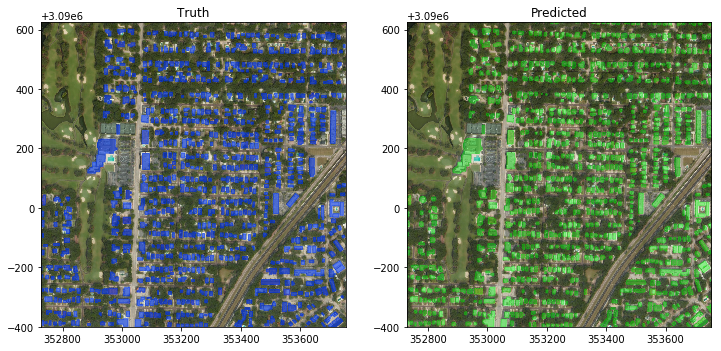

In [10]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].imshow(img, extent=geo_img.extent)
ax[0].set_title("Truth")
plot_poly(contours, ax[0], geo_img.coordinates, TRUE_COLOR)
ax[1].imshow(img, extent=geo_img.extent)
ax[1].set_title("Predicted")
_, pred_ctr, __ = cv2.findContours(thresh(output), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plot_poly(pred_ctr, ax[1], geo_img.coordinates, PRED_COLOR)

Here we combine the plots, which makes it easy to spot where the model failed to label entire buildings.

Text(0.5, 1.0, 'F1/IOU = 0.8203026677460877')

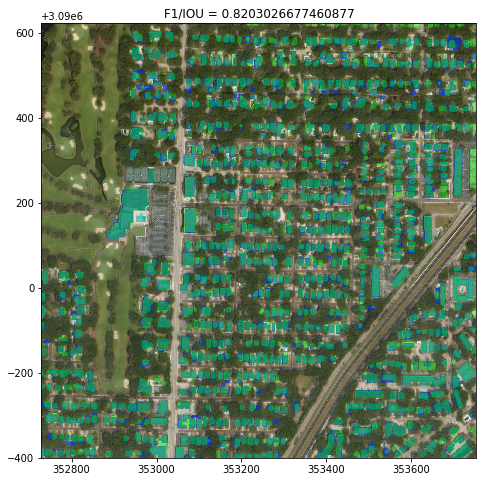

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(img, extent=geo_img.extent)
plot_poly(contours, plt.gca(), geo_img.coordinates, TRUE_COLOR)
plot_poly(pred_ctr, plt.gca(), geo_img.coordinates, PRED_COLOR)
plt.title("F1/IOU = {}".format(score_pred(output, lbl)))

# Extension of Albu to RGB Only
So far unsuccessful attempt to make the model work with only 3 channels again

In [12]:
save_mem = True
if not save_mem:
    # When we only have satellite imagery
    rgb_model = read_model(cfg, 3)

    sd = rgb_model.state_dict()
    skip_layers = rgb_model.first_layer_params_names
    print('skipping: ', [k for k in pretrained_dict.keys() if any(s in k for s in skip_layers)])
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if not any(s in k for s in skip_layers)}
    sd.update(pretrained_dict)
    rgb_model.load_state_dict(sd)

    output3 = predict_on_file(rgb_model, fname, crop=True, channels=3)
    print("F1 / IOU with crop + flip:", 
          score_pred(thresh(output3),lbl))
    print("F1 / IOU with no crop + flip:", 
          score_pred(thresh(predict_on_file(rgb_model, fname, crop=False, channels=3)), lbl))
    print("F1 / IOU with no crop + no flip:",
         score_pred(thresh(predict_on_file(rgb_model, fname, crop=False, channels=3, flips=flip.FLIP_NONE)), lbl))